In [26]:
# Increase cell width
display(HTML("<style>.container { width:100% !important; }</style>"))

HTML{String}("<style>.container { width:100% !important; }</style>")

In [1]:
# Notebook Structure:
# Cell 1: Details regarding model version, TODO list, initialization of required tools/packages
# Cell 2: Reading in data, defininig parameters and initializing result storing structures
# Cell 3: Function for DA SUC
# Cell 4: Script that runs the SUC and stores results

In [5]:
##### Team Sunny Outlook #####
##### CEE 272R Project #####
# Members:
# Vignesh Venugopal
# Austin Park
# Yuchi Sun

####################################
############# Version 3 ############
####################################
    
# TODO: 

# nameplate has to be a [nGENERATORS] sized array.
# Will have to think about what the ideal order of generators should be. Whether tech/emissions based ordering or bus based ordering.
# Coz bus based ordering is preferable for powerflow constraints while tech/emissions based ordering is preferable for the rest of the code, which was built for dataset used in 291
# Probably wise to keep ordering as per tech/emissions and then split the generators later into 2 arrays, one for each bus and feed them into the model for the powerflow constraints.
# Available energy now has to be a [nGenerators, nScenarios, 8760] array
# The data corresponding to scenarios will come in 2 arrays:
  # Capacity factors for solar generators of dims [nSolarGENERATORS, nScenarios, hoursinYear]
  # Capacity factors for wind generators of dims [nWindGENERATORS, nScenarios, hoursinYear]
# Change structure for reading in data and displaying/storing results. Right now only have the YearOf arrays. Not the final Results.csv
# Add in non-anticipativity constraint.
# Decide if we wanna somehow calculate renewable curtailments too.
# Fill in values for variables B, thetaMax, transmissionMax and nGENERATORSBus1
# Define probabilities for each scenario

####################################
######### Initialize tools #########
####################################

# Initialize JuMP to allow mathematical programming models
using JuMP, Gurobi, PyCall, JLD, PyPlot


INFO: Precompiling module JLD.


In [6]:
####################################
########### Import Data ############
####################################

# 1: Plant name
# 2: ORISPL Code
# 3: Plant latitude
# 4: Primary fuel (coal, gas, solar, wind, etc)
# 5: 2016 Capacity factor (for comparisons to model outputs)
# 6: Nameplate Capcity [MW]
# 7: Plant annual CO2 total output emission rate (kg/MWh)
# NOTE: This was the first pass on eGRID data. It was refined,
# cleaned, and split into north and south of 35.79111 N.

eGRIDNorth = readcsv("eGRID_North.csv")[3:end,:]
eGRIDSouth = readcsv("eGRID_South.csv")[3:end,:]
peaker_North = readcsv("peaker_North.csv")[3:end,:]
peaker_South = readcsv("peaker_South.csv")[3:end,:]
generatorData = vcat(eGRIDNorth, eGRIDSouth)

# Convert to [GW]
peaker_North[:,6] = peaker_North[:,6]/1000 # [GW]
peaker_South[:,6] = peaker_South[:,6]/1000 # [GW]
peaker_North[:,7] = peaker_North[:,7]*1000 # [kg CO2 / GWh]
peaker_South[:,7] = peaker_South[:,7]*1000 # [kg CO2 / GWh]

generatorData[:,6] = generatorData[:,6]/1000 # [GWh]
generatorData[:,7] = generatorData[:,7]/1000 # [GWh]

###############################
######### Define Sets #########
###############################

# Set of generator names is Column 1 of generator data
nGENERATORS = size(generatorData,1)
# NORTH
nGENERATORS_N = size(eGRIDNorth,1)
nRenewableGENERATORSBus1 =  findfirst(eGRIDNorth[:,4], "GEOTHERMAL") - 1
nDispatchableBus1 = nGENERATORS_N - nRenewableGENERATORSBus1
nPEAKERS_N = size(peaker_North,1)

# SOUTH
nGENERATORS_S = size(eGRIDSouth,1)
nRenewableGENERATORSBus2 = findfirst(eGRIDSouth[:,4], "GEOTHERMAL") - 1
nDispatchableBus2 = nGENERATORS_S - nRenewableGENERATORSBus2
nPEAKERS_S = size(peaker_South,1)

###################################################
############ Define parameters and data ###########
###################################################

# Time constants
hoursInYear = 24*365 #8760 hours/year
daysInYear = 1 # 1 day run for now

####################################################
### Constants that don't change across scenarios ###
####################################################

# Fuel type order:
    # North: SOLAR, WIND, GEOTHERMAL,BIOMASS, HYDRO, GAS, OIL,
    # South:SOLAR, WIND, GEOTHERMAL,BIOMASS, HYDRO, NUCLEAR, GAS, OIL, COAL

# Find indices where fuel types change
startSolar_N = findfirst(generatorData[:,4], "SOLAR")
startWind_N =  findfirst(generatorData[:,4], "WIND")
startGeo_N =  findfirst(generatorData[:,4], "GEOTHERMAL")
startBio_N = findfirst(generatorData[:,4], "BIOMASS")
startHydro_N = findfirst(generatorData[:,4], "HYDRO")
# No nukes in north
startGas_N = findfirst(generatorData[:,4], "GAS")
startOil_N = findfirst(generatorData[:,4], "OIL")
# No coal in north

startSolar_S = findfirst(eGRIDSouth[:,4], "SOLAR") + nGENERATORS_N
startWind_S =  findfirst(eGRIDSouth[:,4], "WIND") + nGENERATORS_N
startGeo_S =  findfirst(eGRIDSouth[:,4], "GEOTHERMAL") + nGENERATORS_N
startBio_S = findfirst(eGRIDSouth[:,4], "BIOMASS") + nGENERATORS_N
startHydro_S = findfirst(eGRIDSouth[:,4], "HYDRO") + nGENERATORS_N
startNuke_S = findfirst(eGRIDSouth[:,4], "NUCLEAR") + nGENERATORS_N
startGas_S = findfirst(eGRIDSouth[:,4], "GAS") + nGENERATORS_N
startOil_S = findfirst(eGRIDSouth[:,4], "OIL") + nGENERATORS_N
startCoal_S = findfirst(eGRIDSouth[:,4], "COAL") + nGENERATORS_N

# Ramping limits [decimal capacity / hour] Note: decimal = %/100
# Ramp limit is not defined for peaker cuz we don't wanna constrain its ramping capability
rampLimGas = 0.60
rampLimGeo = rampLimGas
rampLimBio = rampLimGas
rampLimCoal = 0.396
rampLimHydro = rampLimCoal
rampLimNuke = 1 # Think about this
rampLimOil = rampLimGas
rampLimPeaker = 1 # Absorb all need for flexibility. May need to constrain more realistically

rampLimit_North =   vcat(rampLimGeo*ones((startBio_N - startGeo_N),1),
                    rampLimBio*ones((startHydro_N - startBio_N),1),
                    rampLimHydro*ones((startGas_N - startHydro_N),1),
                    rampLimGas*ones((startOil_N - startGas_N),1),
                    rampLimOil*ones((1 + nGENERATORS_N - startOil_N),1))

rampLimit_South =   vcat(rampLimGeo*ones((startBio_S - startGeo_S),1),
                    rampLimBio*ones((startHydro_S - startBio_S),1),
                    rampLimHydro*ones((startNuke_S - startHydro_S),1),
                    rampLimNuke*ones((startGas_S - startNuke_S),1),
                    rampLimGas*ones((startOil_S - startGas_S),1),
                    rampLimOil*ones((startCoal_S - startOil_S),1),
                    rampLimCoal*ones((1 + nGENERATORS - startCoal_S),1))

rampLimit_Peaker_N = rampLimPeaker*ones(nPEAKERS_N,1)
rampLimit_Peaker_S = rampLimPeaker*ones(nPEAKERS_S,1)

# Operating Cost in $/GWh
opCostWind = 0
opCostSolar = 0
opCostGas = 23013
opCostGeo = 55
opCostBio = 44801
opCostHydro = 10980
opCostNuke = 25360
opCostOil = 130000
opCostCoal = 36080
opCostPeaker = 45363

opCost_North = vcat(opCostSolar*ones((startWind_N - startSolar_N),1),
                    opCostWind*ones((startGeo_N - startWind_N),1),
                    opCostGeo*ones((startBio_N - startGeo_N),1),
                    opCostBio*ones((startHydro_N - startBio_N),1),
                    opCostHydro*ones((startGas_N - startHydro_N),1),
                    opCostGas*ones((startOil_N - startGas_N),1),
                    opCostOil*ones((1 + nGENERATORS_N - startOil_N),1))

opCost_South = vcat(opCostSolar*ones((startWind_S - startSolar_S),1),
                    opCostWind*ones((startGeo_S - startWind_S),1),
                    opCostGeo*ones((startBio_S - startGeo_S),1),
                    opCostBio*ones((startHydro_S - startBio_S),1),
                    opCostHydro*ones((startNuke_S - startHydro_S),1),
                    opCostNuke*ones((startGas_S - startNuke_S),1),
                    opCostGas*ones((startOil_S - startGas_S),1),
                    opCostOil*ones((startCoal_S - startOil_S),1),
                    opCostCoal*ones((1 + nGENERATORS - startCoal_S),1))

opCost_Peaker_N = opCostPeaker*ones(nPEAKERS_N,1)
opCost_Peaker_S = opCostPeaker*ones(nPEAKERS_S,1)


# Ramping costs [$/(GW/hr)]. This is the approximate cost for each generation
# source to change its output by 1 GW over an hour. 
rampCostSolar = 0
rampCostWind = 0
rampCostGas = 0.615*1000
rampCostGeo = rampCostGas
rampCostBio = rampCostGas
rampCostHydro = rampCostGas
rampCostNuke = 0.1*1000
rampCostCoal = 2.214*1000
rampCostOil = rampCostGas
rampCostPeaker = 0.615*1000 #NOTE: Should probably be less than regular gas, no?

rampCost_North =    vcat(rampCostSolar*ones((startWind_N - startSolar_N),1),
                    rampCostWind*ones((startGeo_N - startWind_N),1),
                    rampCostGeo*ones((startBio_N - startGeo_N),1),
                    rampCostBio*ones((startHydro_N - startBio_N),1),
                    rampCostHydro*ones((startGas_N - startHydro_N),1),
                    rampCostGas*ones((startOil_N - startGas_N),1),
                    rampCostOil*ones((1 + nGENERATORS_N - startOil_N),1))

rampCost_South =    vcat(rampCostSolar*ones((startWind_S - startSolar_S),1),
                    rampCostWind*ones((startGeo_S - startWind_S),1),
                    rampCostGeo*ones((startBio_S - startGeo_S),1),
                    rampCostBio*ones((startHydro_S - startBio_S),1),
                    rampCostHydro*ones((startNuke_S - startHydro_S),1),
                    rampCostNuke*ones((startGas_S - startNuke_S),1),
                    rampCostGas*ones((startOil_S - startGas_S),1),
                    rampCostOil*ones((startCoal_S - startOil_S),1),
                    rampCostCoal*ones((1 + nGENERATORS - startCoal_S),1))

rampCost_Peaker_N = rampCostPeaker*ones(nPEAKERS_N,1)
rampCost_Peaker_S = rampCostPeaker*ones(nPEAKERS_S,1)

# Minimum output if 'ON' [Fraction of nameplate]
# Only for nuke, gas and coal. NOT peaker, solar or wind.
PminSolar = 1e-12  # Not exactly 0 to ensure dispatch is exactly 0 when we're not dispatching that particular generator in minimum 'ON' power constraint
PminWind = 1e-12
PminGas = 0.25
PminGeo = PminGas
PminBio = PminGas
PminHydro = 1e-4 # NOTE: I'm assuming you can operate hydro at any level
PminNuke = 0.85 # NOTE: Changed based on CF in eGRID
PminOil = PminGas
PminCoal = 0.3
PminPeaker = 1e-4 # Allow full flexibility

Pmin_North =    vcat(PminSolar*ones((startWind_N - startSolar_N),1),
                PminWind*ones((startGeo_N - startWind_N),1),
                PminGeo*ones((startBio_N - startGeo_N),1),
                PminBio*ones((startHydro_N - startBio_N),1),
                PminHydro*ones((startGas_N - startHydro_N),1),
                PminGas*ones((startOil_N - startGas_N),1),
                PminOil*ones((1 + nGENERATORS_N - startOil_N),1))

Pmin_South =    vcat(PminSolar*ones((startWind_S - startSolar_S),1),
                PminWind*ones((startGeo_S - startWind_S),1),
                PminGeo*ones((startBio_S - startGeo_S),1),
                PminBio*ones((startHydro_S - startBio_S),1),
                PminHydro*ones((startNuke_S - startHydro_S),1),
                PminNuke*ones((startGas_S - startNuke_S),1),
                PminGas*ones((startOil_S - startGas_S),1),
                PminOil*ones((startCoal_S - startOil_S),1),
                PminCoal*ones((1 + nGENERATORS - startCoal_S),1))

Pmin_Peaker_N = PminPeaker*ones(nPEAKERS_N,1)
Pmin_Peaker_S = PminPeaker*ones(nPEAKERS_S,1)

# Startup cost [$/GW]
startupCostSolar = 0
startupCostWind = 0
startupCostGas = 44000
startupCostGeo = startupCostGas
startupCostBio = startupCostGas
startupCostHydro = 1e-4
startupCostNuke = 3000 #TODO: Check this number
startupCostOil = startupCostGas
startupCostCoal = 61000
startupCostPeaker = 0.5*startupCostGas

startupCost_North = vcat(startupCostSolar*ones((startWind_N - startSolar_N),1),
                    startupCostWind*ones((startGeo_N - startWind_N),1),
                    startupCostGeo*ones((startBio_N - startGeo_N),1),
                    startupCostBio*ones((startHydro_N - startBio_N),1),
                    startupCostHydro*ones((startGas_N - startHydro_N),1),
                    startupCostGas*ones((startOil_N - startGas_N),1),
                    startupCostOil*ones((1 + nGENERATORS_N - startOil_N),1))

startupCost_South = vcat(startupCostSolar*ones((startWind_S - startSolar_S),1),
                    startupCostWind*ones((startGeo_S - startWind_S),1),
                    startupCostGeo*ones((startBio_S - startGeo_S),1),
                    startupCostBio*ones((startHydro_S - startBio_S),1),
                    startupCostHydro*ones((startNuke_S - startHydro_S),1),
                    startupCostNuke*ones((startGas_S - startNuke_S),1),
                    startupCostGas*ones((startOil_S - startGas_S),1),
                    startupCostOil*ones((startCoal_S - startOil_S),1),
                    startupCostCoal*ones((1 + nGENERATORS - startCoal_S),1))

startupCost_Peaker_N = startupCostPeaker*ones(nPEAKERS_N,1)
startupCost_Peaker_S = startupCostPeaker*ones(nPEAKERS_S,1)

# CO2 Intensity [kg CO2 / GWh]
carbonEmissions = generatorData[:,7]
carbonEmissions_Peaker_N = peaker_North[:,7]
carbonEmissions_Peaker_S = peaker_South[:,7]

# Nameplate Capacities [GW]
nameplate = generatorData[:,6] # [GW]
nameplate_Peaker_N = peaker_North[:,6] # [GW]
nameplate_Peaker_S = peaker_South[:,6] # [GW]

# Transmission line imaginary admittance
B = 10 # Educated guess. Unit is GW
# Transmission and phase angle limits
transmissionMax = 100 #[GW] # NOTE: We need to think of a reasonable number
thetaMax = 10*pi/180 #[radians]


# Available energy [g,s,t] in GWh
# Presently 10 scenarios and 24 hrs
@pyimport pickle
f = open("available_energy_20.pkl", "r")
availableEnergy = pickle.load(f) #MWh
close(f)
availableEnergy[availableEnergy.<0] = 0 # Get rid of any negatives that may have resulted from the random sampling.
availableEnergy /= 1000 #GWh

# Probability of realizing a particular scenario in a particular hour (0 to 1)
# Presently (10,24)
@pyimport pickle
f = open("weights_20.pkl", "r")
probability = pickle.load(f) 
close(f)

# Hourly demand in GWh. Presently, for 24 hours.
demandNorth = readcsv("north_load.csv")[2:25,6] # MWh
demandAtHourBus1 = demandNorth / 1000 # GWh

demandSouth = readcsv("south_load.csv")[2:25,6] # MWh
demandAtHourBus2 = demandSouth / 1000 # GWh

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, C_NULL)) <type 'exceptions.ValueError'>
ValueError('unsupported pickle protocol: 4',)
  File "C:\Users\austi\.julia\v0.6\Conda\deps\usr\lib\pickle.py", line 1384, in load
    return Unpickler(file).load()
  File "C:\Users\austi\.julia\v0.6\Conda\deps\usr\lib\pickle.py", line 864, in load
    dispatch[key](self)
  File "C:\Users\austi\.julia\v0.6\Conda\deps\usr\lib\pickle.py", line 892, in load_proto
    raise ValueError, "unsupported pickle protocol: %d" % proto
[39m

In [30]:
####################################
##### Function for DA SUC ##########
####################################

function run_DA_SUC(startHour, endHour, lastHourgeneratePower, lastHourdispatch)
    # Define the model name and solver. In this case, model name is "m"
    m = Model(solver=GurobiSolver())

    ####################################
    ######## Decision variables ########
    ####################################

    # Power to generate for every hour of the year, from every source [GW]
    @variable(m, generatePower[1:nGENERATORS,  1:nScenarios, startHour:endHour] >= 0)
    # Ramping variable: Absolute change in power output (hour h minus hour h-1) [GW/hr]
    @variable(m, ramp[1:nGENERATORS, 1:nScenarios, startHour:endHour] >= 0)
    # Keep account of whether or not a plant started operation in hour 'h'.
    @variable(m, startup[1:nGENERATORS, 1:nScenarios, startHour:endHour] >= 0)
    # Emissions generated as a result of power generation. Not constrained right now.
    @variable(m, carbonEmitted[ 1:nScenarios, startHour:endHour] >= 0)
    # Binary variable- 1 if Generator 'g' was operational in hour 'h',0 otherwise.
    @variable(m, dispatch[1:nGENERATORS, 1:nScenarios, startHour:endHour], Bin)
    # Phase angle at each bus in the network
    @variable(m, theta[1:nBuses, 1:nScenarios, startHour:endHour])


    ######################################
    ############# Constraints ############
    ######################################

    # For every hour in every scenario,  supply equals demand in each bus
    # DC OPF Assumptions in place. No real losses
    @constraint(m, [s=1:nScenarios, h=startHour:endHour], sum(generatePower[g,s,h] for g in 1:nGENERATORSBus1) - demandAtHourBus1[h] == B * (theta[1,s,h] - theta[2,s,h]))
    @constraint(m, [s=1:nScenarios, h=startHour:endHour], sum(generatePower[g,s,h] for g in nGENERATORSBus1+1:nGENERATORS) - demandAtHourBus2[h] == B * (theta[2,s,h] - theta[1,s,h]))
    
    # Supplied power has to fall between min 'ON' power and availability for that hour
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour:endHour], dispatch[g,s,h] * minGeneratePower[g] <= generatePower[g,s,h])
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour:endHour], generatePower[g,s,h] <= dispatch[g,s,h] * availableEnergy[g,s,h])

    # Keep account of how much CO2 is emitted in each hour of each scenario
    @constraint(m, [s=1:nScenarios, h=startHour:endHour], carbonEmitted[s,h] == sum(generatePower[g,s,h] * carbonEmissions[g] for g=1:nGENERATORS))

    # Ramping constraint [decimal capacity / hr]
    # Note: Applies to all but wind, solar, and peakers.
    
    # For Generators in Bus 1(North)
    # For 1st hour in each day of each scenario
    @constraint(m, [g=1:nDispatchableBus1, s=1:nScenarios, h=startHour], -rampLimit_North[g] <= (generatePower[g+nRenewableGENERATORSBus1,s,h] - lastHourgeneratePower[g+nRenewableGENERATORSBus1]) / nameplate[g+nRenewableGENERATORSBus1])
    @constraint(m, [g=1:nDispatchableBus1, s=1:nScenarios, h=startHour], (generatePower[g+nRenewableGENERATORSBus1,s,h] - lastHourgeneratePower[g+nRenewableGENERATORSBus1]) / nameplate[g+nRenewableGENERATORSBus1] <= rampLimit_North[g])
    # For rest of hours in each day of each scenario
    @constraint(m, [g=1:nDispatchableBus1, s=1:nScenarios, h=startHour+1:endHour], -rampLimit_North[g] <= (generatePower[g+nRenewableGENERATORSBus1,s,h] - generatePower[g+nRenewableGENERATORSBus1,s,h-1]) / nameplate[g+nRenewableGENERATORSBus1])
    @constraint(m, [g=1:nDispatchableBus1, s=1:nScenarios, h=startHour+1:endHour], (generatePower[g+nRenewableGENERATORSBus1,s,h] - generatePower[g+nRenewableGENERATORSBus1,s,h-1]) / nameplate[g+nRenewableGENERATORSBus1] <= rampLimit_North[g])
    
    # For Generators in Bus 2(South)
    # For 1st hour in each day of each scenario
    @constraint(m, [g=1:nDispatchableBus2, s=1:nScenarios, h=startHour], -rampLimit_South[g] <= (generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] - lastHourgeneratePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2]) / nameplate[g+nGENERATORSBus1+nRenewableGENERATORSBus2])
    @constraint(m, [g=1:nDispatchableBus2, s=1:nScenarios, h=startHour], (generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] - lastHourgeneratePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2]) / nameplate[g+nGENERATORSBus1+nRenewableGENERATORSBus2] <= rampLimit_South[g])
    # For rest of hours in each day of each scenario
    @constraint(m, [g=1:nDispatchableBus2, s=1:nScenarios, h=startHour+1:endHour], -rampLimit_South[g] <= (generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] - generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h-1]) / nameplate[g+nGENERATORSBus1+nRenewableGENERATORSBus2])
    @constraint(m, [g=1:nDispatchableBus2, s=1:nScenarios, h=startHour+1:endHour], (generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] - generatePower[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h-1]) / nameplate[g+nGENERATORSBus1+nRenewableGENERATORSBus2] <= rampLimit_South[g])
    
    # Ramp will ultimately be the absolute change in power generated by each generator in subsequent time steps.
    
    # For 1st hour in each day of each scenario
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour], lastHourgeneratePower[g] - generatePower[g,s,h] <= ramp[g,s,h])
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour], generatePower[g,s,h] - lastHourgeneratePower[g] <= ramp[g,s,h])
    # For rest of hours in each day of each scenario
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour+1:endHour], generatePower[g, s, h-1] - generatePower[g, s, h] <= ramp[g,s,h])
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour+1:endHour], generatePower[g, s, h] - generatePower[g, s, h-1] <= ramp[g,s,h])

    # Check if any generator started operating in hour 'h'
    # For 1st hour in each day of each scenario
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour], startup[g,s,h] >= dispatch[g,s,h] - lastHourdispatch[g])
    # For rest of hours in each day of each scenario
    @constraint(m, [g=1:nGENERATORS, s=1:nScenarios, h=startHour+1:endHour], startup[g,s,h] >= dispatch[g,s,h] - dispatch[g, s, h-1])
    
    # Ensure that transmission line doesn't carry more than permissible power in every hour of every scenario.
    @constraint(m, [s=1:nScenarios, h=startHour:endHour], -transmissionMax <= B * (theta[1,s,h] - theta[2,s,h]))
    @constraint(m, [s=1:nScenarios, h=startHour:endHour], B * (theta[1,s,h] - theta[2,s,h]) <= transmissionMax)
    
    # Ensure that voltage phase angles at buses don't change beyond permissible limits and that phase angle at slack bus is precisely = 0 
    @constraint(m, [b=1:nBuses, s=1:nScenarios, h=startHour:endHour], -thetaMax <= theta[b,s,h])
    @constraint(m, [b=1:nBuses, s=1:nScenarios, h=startHour:endHour], theta[b,s,h] <= thetaMax)
    @constraint(m, [b=slackBus, s=1:nScenarios, h=startHour:endHour], theta[b,s,h] == 0)

    # Define expressions to be used in objective function
    @expression(m, OperatingCost, sum(sum(probability[s,h] * sum(generatePower[g,s,h] * opCost[g] for g in 1:nGENERATORS) for h in startHour:endHour) for s in 1:nScenarios))
    @expression(m, StartUpCost, sum(sum(probability[s,h] * sum(startup[g,s,h] * startupCost[g]  for g=1:nGENERATORS) for h=startHour:endHour) for s=1:nScenarios))
    @expression(m, RampingCost, sum(sum(probability[s,h] * sum(ramp[g,s,h]*rampCost[g] for g=1:nGENERATORS) for h=startHour:endHour) for s in 1:nScenarios))
    
    # Non anticipativity constraints
    # Decision variables 'dispatch' and startup variables 'startup' remain the same for all dispatchable generators across all scenarios
    
    # For generators in Bus 1:
    @constraint(m, [g=1:nDispatchableBus1, s=2:nScenarios, h=startHour:endHour], dispatch[g+nRenewableGENERATORSBus1,s,h] == dispatch[g+nRenewableGENERATORSBus1,1,h])
    @constraint(m, [g=1:nDispatchableBus1, s=2:nScenarios, h=startHour:endHour], startup[g+nRenewableGENERATORSBus1,s,h] == startup[g+nRenewableGENERATORSBus1,1,h])
    
    # For generators in Bus 2:
    @constraint(m, [g=1:nDispatchableBus2, s=2:nScenarios, h=startHour:endHour], dispatch[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] == dispatch[g+nGENERATORSBus1+nRenewableGENERATORSBus2,1,h])
    @constraint(m, [g=1:nDispatchableBus2, s=2:nScenarios, h=startHour:endHour], startup[g+nGENERATORSBus1+nRenewableGENERATORSBus2,s,h] == startup[g+nGENERATORSBus1+nRenewableGENERATORSBus2,1,h])
    

    ######################################
    ######## Objective Function ##########
    ######################################

    @objective(m, Min,  OperatingCost + StartUpCost + RampingCost)
    
    ####################################
    ########### Solve Model ############
    ####################################

    tic() # start timer
#     print(m)
    solve(m)
    global evalTime = toc() # stop timer
    # Return decision variables that were solved for.
    return getvalue(generatePower[:,:,startHour:endHour]), getvalue(ramp[:,:,startHour:endHour]), getvalue(carbonEmitted[:,startHour:endHour]), getvalue(dispatch[:,:,startHour:endHour]), getvalue(startup[:,:,startHour:endHour]), getobjectivevalue(m), evalTime
end

run_DA_Market (generic function with 1 method)

In [31]:
####################################
####### Script for DA SUC ##########
####################################
minGeneratePower = nameplate .* vcat(Pmin_North, Pmin_South) # GW (1315,1)
startupCost = vcat(startupCost_North, startupCdost_South) # $/GW (1315,1)
rampCost = vcat(rampCost_North, rampCost_South) # $/GW (1315,1)
opCost = vcat(opCost_North, opCost_South) # $/GWh (1315,1)
nGENERATORSBus1 = nGENERATORS_N 
nGENERATORSBus2 = nGENERATORS_S
nScenarios = size(availableEnergy)[2]d
nBuses = 2
slackBus = 1
startHour = 1
endHour = 24
lastHourgeneratePower = zeros(1,nGENERATORS)
lastHourdispatch = zeros(1,nGENERATORS)
powerGeneration, Ramp, carbonEmission, Dispatch, Startup, Cost = run_DA_SUC(startHour, endHour, lastHourgeneratePower, lastHourdispatch)
# Change Result number based on data used.
#save("Results_SUC_20.jld","powerGeneration",powerGeneration,"Ramp",Ramp,"carbonEmission",carbonEmission,"Dispatch",Dispatch,"Startup",Startup,"Cost",Cost)

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2185056 rows, 1263120 columns and 5446281 nonzeros
Variable types: 947520 continuous, 315600 integer (315600 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+03]
  Objective range  [5e-07, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1281057 rows and 919629 columns (presolve time = 6s) ...
Presolve removed 1281057 rows and 919629 columns
Presolve time: 6.95s
Presolved: 903999 rows, 343491 columns, 2584767 nonzeros
Variable types: 312330 continuous, 31161 integer (31161 binary)
Found heuristic solution: objective 2.650842e+07
Found heuristic solution: objective 2.650818e+07

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.00000

elapsed time: 2018.213003205 seconds


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4.50

In [ ]:
# Calculate expectation of power generation: (probability * generation)
wtdPowerGen = zeros(Float64, nGENERATORS, endHour)
for i in 1:nScenarios
    for j in 1:endHour
        wtdPowerGen[:,j] += powerGeneration[:,i,j] .* probability[i,j]
    end
end

# Total Generation [GW]
totalSUCGen = sum(wtdPowerGen,1)
totalSUCGenN = sum(wtdPowerGen[1:nGENERATORSBus1,:],1)
totalSUCGenS = sum(wtdPowerGen[startSolar_S:end,:],1)

In [ ]:
####################################
########## Process DCOPF ###########
####################################

# Total Generation [GW]
totalSUCGen = sum(wtdPowerGen,1)
totalSUCGenN = sum(wtdPowerGen[1:nGENERATORSBus1,:],1)
totalSUCGenS = sum(wtdPowerGen[startSolar_S:end,:],1)

# North: SOLAR, WIND, GEOTHERMAL,BIOMASS, HYDRO, GAS, OIL
solarN = sum(wtdPowerGen[1:startWind_N-1,:],1)
windN = sum(wtdPowerGen[startWind_N:startGeo_N-1,:],1)
geoN = sum(wtdPowerGen[startGeo_N:startBio_N-1,:],1)
bioN = sum(wtdPowerGen[startBio_N:startHydro_N-1,:],1)
hydroN = sum(wtdPowerGen[startHydro_N:startGas_N-1,:],1)
gasN = sum(wtdPowerGen[startGas_N:startOil_N-1,:],1)
oilN = sum(wtdPowerGen[startOil_N:startSolar_S-1,:],1)
# South:SOLAR, WIND, GEOTHERMAL,BIOMASS, HYDRO, NUCLEAR, GAS, OIL, COAL
solarS = sum(wtdPowerGen[startSolar_S:startWind_S-1,:],1)
windS = sum(wtdPowerGen[startWind_S:startGeo_S-1,:],1)
geoS = sum(wtdPowerGen[startGeo_S:startBio_S-1,:],1)
bioS = sum(wtdPowerGen[startBio_S:startHydro_S-1,:],1)
hydroS = sum(wtdPowerGen[startHydro_S:startNuke_S-1,:],1)
nukeS = sum(wtdPowerGen[startNuke_S:startGas_S-1,:],1)
gasS = sum(wtdPowerGen[startGas_S:startOil_S-1,:],1)
oilS = sum(wtdPowerGen[startOil_S:startCoal_S-1,:],1)
coalS = sum(wtdPowerGen[startCoal_S:end,:],1)
# Total by type
solar = solarN + solarS
wind = windN + windS
geo = geoN + geoS
bio = bioN + bioS
hydro = hydroN + hydroS
nuke = nukeS
gas = gasN + gasS
oil = oilN + oilS
coal = coalS
# Energy mix
pcSolar = solar/totalGen
pcWind = wind/totalGen
pcGeo = geo/totalGen
pcBio = bio/totalGen
pcHydro = hydro/totalGen
pcNuke = nuke/totalGen
pcGas = gas/totalGen
pcOil = oil/totalGen
pcCoal = coal/totalGen

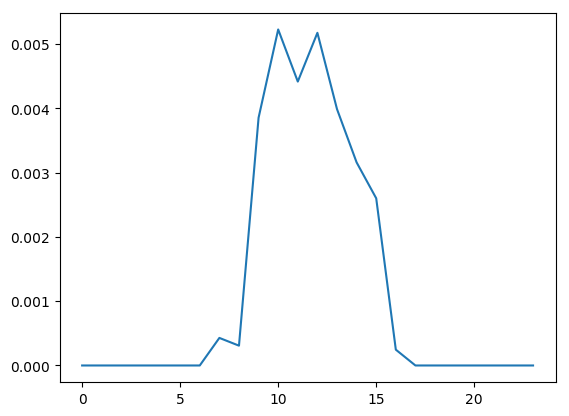

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006CE97390>

In [32]:
# Sanity check
plot(powerGeneration[2,1,:])
print(evalTime)